In [5]:
#CL_Zofia_One_Class test file

import numpy as np
import sys
import matplotlib.pyplot as plt

In [6]:
plt.rcParams.update(
    {
        "xtick.direction": "in",
        "ytick.direction": "out",
        "ytick.right": False,
        "xtick.top": False,
        "ytick.left": True,
        "xtick.bottom": False,
        "figure.facecolor": "1",
        "savefig.facecolor": "1",
        "savefig.dpi": 600,
        "figure.dpi": 600,
        "savefig.bbox": "tight",
        "font.size": 7,
        "font.family": "serif",
        "lines.markersize": 4,
        "lines.linewidth": 1,
        'axes.axisbelow' : True
    }
)

# Define colors with names
colors = {
    "red": "#D22B2B",
    "blue": "#377eb8",
    "green": "#4daf4a",
    "purple": "#702963",
    "orange": "#ff7f00",
    "yellow": "#d1b43f",
    "brown": "#a65628",
    "pink": "#f781bf",
    "grey": "#999999",
    "dark grey": "#5b5b5b",
    "black": "#000000",
    "white": "#ffffff"
}

# Golden ratio
figure_size_x = 6.0462
figure_size_y = figure_size_x/1.618

In [7]:
class LBM_2_Carlemann1:
    def __init__(self, N_grid, h_init, u_init):
        # Constants for the D1Q3 lattice (1D, 3 velocities)
        self.w = np.array([2/3, 1/6, 1/6])  # Weights for D1Q3 lattice
        self.e = np.array([0, 1, -1])  # Lattice directions: [0, +1, -1]
        self.c_s = 1/np.sqrt(3)  # Speed of sound for D1Q3 lattice...is this the delta_x\delta_t ??
        self.kn = 0.1 #Knudsen number, much less than 1 for chapman-enskogg expansion

        # Parameters
        self.tau = 1.0  # Relaxation time
        self.nu = 0.08  # dissipation rate
        self.Nx = N_grid  # Number of grid points...my code for the F matrices makes the kernel die if this number is 81 or higher
        self.L = 0.0001 # Length of the domain (in meters)
        #self.delta_t = self.L/self.Nx
        self.dx = self.L/self.Nx
        self.delta_t =  (self.dx*self.c_s**2)/np.sqrt(h_init[-1]*9.81)
        self.g = 9.81*(self.delta_t**2/self.dx)  # Acceleration due to gravity (m/s^2)

        # Initialize macroscopic variables: density(height) and velocity field
        self.h = h_init  # height field
        self.u = u_init  # Velocity field

        # Initialize distribution functions (f_i), f has 3 directions (D1Q3)
        self.f = np.zeros((self.Nx, 3))  # Distribution functions for D1Q3
        self.feq = np.zeros_like(self.f)  # Equilibrium distribution functions

     #return a 1D array with one non-zero element of value 1 at specified index
    def one_nonzero(self,dim, n):
        array = np.zeros((dim))
        if n>-1 and n<dim:
            array[n] = 1
        return array
    #make the F matrices for the collision matrix for n grid points
    def gen_F(self):
        f1 = np.zeros((3,3))
        f1[0,1] = f1[0,2] = 1
        f1[1,1] = 1/(2*self.c_s) - 1
        f1[1,2] = -1/(2*self.c_s)
        f1[2,1] = -1/(2*self.c_s)
        f1[2,2] = 1/(2*self.c_s) -1
        f1 = (1/(self.tau*self.kn))*f1
        
        f2 = np.zeros((3,9))
        for i in range(9):
            f2[0,i] = -self.g
            f2[1,i]  = self.g
            f2[2,i]  = self.g
        f2[0,4] = f2[0,4] -4 
        f2[0,8] = f2[0,8] -4
        f2[0,5] = f2[0,5] +4 
        f2[0,7] = f2[0,7] +4
        for i in range(2):
            f2[i+1, 4] = f2[i+1, 4] +2
            f2[i+1, 8] = f2[i+1, 8] +2

            f2[i+1, 5] = f2[i+1, 5] -2
            f2[i+1, 7] = f2[i+1, 7] -2
        f2 = (1/(2*self.tau*self.kn*self.c_s**2))*f2

        f3 = np.zeros((3,9))
        f3[0,4] = 2
        f3[0,8] = 2
        f3[0,5] = -2 
        f3[0,7] = -2
        for i in range(2):
            f3[i+1, 4] = -1
            f3[i+1, 8] = -1

            f3[i+1, 5] = 1
            f3[i+1, 7] = 1
        f3 = np.hstack((f3,f3,f3))
        f3 = (1/(2*self.tau*self.kn*self.c_s**2))*f3

        #generalise to n grid points...strategy is to stack matrices, not create matrix of matrices I think...?
        n = self.Nx
        Q = len(self.e)
        '''
        F1 = np.zeros((dim,Q, dim*Q))
        F2 = np.zeros((dim,Q, (dim**2)*(Q**2)))
        F3 = np.zeros((dim,Q, (dim**3)*(Q**3)))
        '''
        I = self.one_nonzero(n, 0)
        F1 = np.kron(I, f1)
        F2 = np.kron(np.kron(I,I) , f2)
        F3 = np.kron(np.kron(np.kron(I, I), I), f3)


        for i in range(n-1):
            I = self.one_nonzero(n, i+1)
            F1 = np.vstack((F1, np.kron(I, f1)))
            F2 = np.vstack((F2, np.kron(np.kron(I,I) , f2)))
            F3 = np.vstack((F3, np.kron(np.kron(np.kron(I, I), I), f3)))
        
        return F1,F2,F3, f1, f2, f3
        
    #make A matrices for the collision matrix
    def gen_A(self, F1,F2,F3):
        A11 = F1
        A12 = F2
        A13 = F3
        Q= len(self.e)
        n = self.Nx
        dim = n*Q
        I = np.identity(dim)
        A22 = np.kron(F1,I) + np.kron(I, F1)
        #slows down at A22, kernel dies after with Nx = 50
        A23 = np.kron(F2,I) + np.kron(I, F2)
        A33 = np.kron(np.kron(F1,I), I) + np.kron(np.kron(I,F1), I) + np.kron(np.kron(I,I), F1)

        return A11, A12, A13, A22, A23, A33
    #make collision matrix 
    def gen_collision(self, A11, A12, A13, A22, A23, A33):
        C1 = np.vstack((A11,np.zeros((A22.shape[0]+A33.shape[0],A11.shape[1]))))
        C2 = np.vstack((A12,A22,np.zeros((A33.shape[0],A12.shape[1]))))
        C3 = np.vstack((A13, A23, A33))

        Cc = np.hstack((C1,C2,C3))

        print("Just made collision matrix...no time step addition")

        return Cc
    
    #make streaming matrix, restricted to NN, 2nd order accuracy...only makes sense if we are considering more than 1 grid point
    def gen_streaming(self):
        Q= len(self.e)
        n = self.Nx
        inv_delta = n/(2*self.L)
        dim = n*Q
        I = np.identity(dim)
        S = np.zeros((dim, dim))
        
        """        
        for i in range(dim):
            #deal with edge case here...periodic or bounce back BC...here I do code for periodic
            if i<Q:
                S[i,i+Q] = inv_delta*self.e[(i%3)]
                S[i, (dim-Q)+i] = -inv_delta*self.e[(i%3)]
            elif i>dim -Q - 1:
                S[i,dim-i] = inv_delta*self.e[(i%3)]
                S[i,i-Q] = -inv_delta*self.e[(i%3)]
            else:
                S[i,i+Q] = inv_delta*self.e[(i%3)]
                S[i,i-Q] = -inv_delta*self.e[(i%3)]
            """
        
        """ 
        #main_diagonal = [1] * (self.Nx * len(self.e))
        upper_diagonal = [-1] * ((self.Nx) * len(self.e)-3)
        lower_diagonal = [-1] * ((self.Nx) * len(self.e)-3)

        # Create the matrix
        #S =  np.diag(main_diagonal, k=0)     # Main diagonal
        S += np.diag(upper_diagonal, k=3)    # Upper diagonal 
        S += np.diag(lower_diagonal, k=-3)   # Lower diagonal 
       
        #add periodic BC
        S[0,-3]=S[1,-2]=S[2,-1]=-1
        S[-3,0]=S[-2,1]=S[-1,2]=1
        
        #multiply with e_m
        S[::3, :] = 0 
        S[1::3, :] *= 1 
        S[2::3, :] *= -1 

        S = (inv_delta)* S
        
        """

        main_diagonal = [1] * (self.Nx * len(self.e))
        #upper_diagonal = [-1] * ((self.Nx) * len(self.e)-3)
        lower_diagonal = [-1] * ((self.Nx) * len(self.e)-3)

        # Create the matrix
        S =  np.diag(main_diagonal, k=0)     # Main diagonal
        #S += np.diag(upper_diagonal, k=3)    # Upper diagonal 
        S += np.diag(lower_diagonal, k=-3)   # Lower diagonal 
       
        #add periodic BC
        S[0,-3]=S[1,-2]=S[2,-1]=-1
        #S[-3,0]=S[-2,1]=S[-1,2]=1
        
        #multiply with e_m
        S[::3, :] = 0 
        S[1::3, :] *= 1 
        S[2::3, :] *= -1 
           

        S = (inv_delta)* S

        #print(S)


        

        B11 = S
        B22 = np.kron(S,I) + np.kron(I, S)
        B33 = np.kron(np.kron(S,I), I) + np.kron(np.kron(I,S), I) + np.kron(np.kron(I,I), S)

        C1 = np.vstack((B11,np.zeros((B22.shape[0]+B33.shape[0],B11.shape[1]))))
        C2 = np.vstack((np.zeros((B11.shape[0],B22.shape[1])),B22,np.zeros((B33.shape[0],B22.shape[1]))))
        C3 = np.vstack((np.zeros((B11.shape[0]+B22.shape[0],B33.shape[1])), B33))

        Cs = np.hstack((C1,C2,C3))

        print("Just made streaming matrix...no time step addition")

        return Cs, B11,B22,B33,S

In [8]:
# x = np.arange(10845)  # Example: [0, 1, 2, ..., 10844]
def extract_phi(x, subvector_dim, N):
    if len(x) < N * subvector_dim:
        raise ValueError("The length of x is too small for the given N and subvector_dim.") 
    # Extract phi components
    phi = [x[i * subvector_dim : (i + 1) * subvector_dim] for i in range(N)]
    return phi

def phi_truncation(phi_list, N):
    num_values = 3 * N
    truncated_phi = [phi[:num_values] for phi in phi_list]
    return truncated_phi

def divide_truncated_phi(truncated_phi, N):
    result = []
    for phi in truncated_phi:
        # Ensure the truncated phi has at least 3 * N elements
        if len(phi) < 3 * N:
            raise ValueError("Each truncated phi must have at least 3 * N elements.")
        
        # Divide phi into N groups of 3
        groups = [phi[3 * i : 3 * (i + 1)] for i in range(N)]
        result.extend(groups)
    
    return result 

In [9]:
# N_grid = 10
# h_init = [0.1,0.1,0.101,0.101, 0.101, 0.101, 0.101, 0.101, 0.101, 0.101]
# u_init = [0,0,0,0,0]
# N_time = 5  # Number of time steps
# print("the num of grid points is: ", N_grid)
# print("the num of time steps is: ", N_time)

In [5]:
kappas_gp = []
F_norms_gp = []
dims_gp = []
N_grid_list = [3,4,5]
for N_grid in N_grid_list:
    h_init = np.random.rand(N_grid)
    u_init = np.random.rand(N_grid)
    N_time = 2  # Number of time steps

    Gen = LBM_2_Carlemann1(N_grid, h_init, u_init )

    F1,F2,F3, f1,f2,f3  = Gen.gen_F()

    A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1,F2,F3)

    Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
    Cs, B11,B22,B33,S = Gen.gen_streaming()

    CL_LBE_Matrix =  Cc-Cs

    N_grid = Gen.Nx

    def embed_matrix(C, delta_t, num_steps):
        """
        Embeds a matrix C into a larger matrix A with specified properties.

        Parameters:
            C (np.ndarray): The matrix to embed (must be square).
            delta_t (float): The length of each time step.
            num_steps (int): The number of time steps (and thus of cascaded blocks in A).

        Returns:
            np.ndarray: The constructed matrix A.
        """
        # Validate inputs
        if not (isinstance(C, np.ndarray) and C.ndim == 2 and C.shape[0] == C.shape[1]):
            raise ValueError("C must be a square matrix.")

        # Identity matrix with the same size as C
        Id = np.eye(C.shape[0])

        delta_t = 1/np.linalg.norm(C)

        # Compute -O = -(Id + delta_t * C)
        O = -(Id + delta_t * C)

        # Size of the large matrix A
        A_size = num_steps * C.shape[0]

        # Initialize A as a zero matrix
        A = np.zeros((A_size, A_size))

        # Fill in the diagonal blocks
        for i in range(num_steps):
            # Main diagonal (Identity blocks)
            start_idx = i * C.shape[0]
            A[start_idx:start_idx + C.shape[0], start_idx:start_idx + C.shape[0]] = Id

            # Secondary diagonal (-O blocks)
            if i > 0:
                prev_idx = (i - 1) * C.shape[0]
                A[start_idx:start_idx + C.shape[0], prev_idx:prev_idx + C.shape[0]] = O

        return A

    delta_t = Gen.delta_t
    Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
    print("Shape of the Matrix to invert:", Lin_Euler_Matrix.shape)

    dims_gp.append(Lin_Euler_Matrix.shape[0])
    # kappas_gp.append(np.linalg.cond(Lin_Euler_Matrix))
    U, s, Vh = np.linalg.svd(Lin_Euler_Matrix)
    kappas_gp.append(s[0] / s[-1])
    F_norms_gp.append(np.linalg.norm(Lin_Euler_Matrix))

Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (1638, 1638)
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (3768, 3768)
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (7230, 7230)


In [6]:
for N_grid in [6]:
    h_init = np.random.rand(N_grid)
    u_init = np.random.rand(N_grid)
    N_time = 2  # Number of time steps

    Gen = LBM_2_Carlemann1(N_grid, h_init, u_init )

    F1,F2,F3, f1,f2,f3  = Gen.gen_F()

    A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1,F2,F3)

    Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
    Cs, B11,B22,B33,S = Gen.gen_streaming()

    CL_LBE_Matrix =  Cc-Cs

    N_grid = Gen.Nx

    def embed_matrix(C, delta_t, num_steps):
        """
        Embeds a matrix C into a larger matrix A with specified properties.

        Parameters:
            C (np.ndarray): The matrix to embed (must be square).
            delta_t (float): The length of each time step.
            num_steps (int): The number of time steps (and thus of cascaded blocks in A).

        Returns:
            np.ndarray: The constructed matrix A.
        """
        # Validate inputs
        if not (isinstance(C, np.ndarray) and C.ndim == 2 and C.shape[0] == C.shape[1]):
            raise ValueError("C must be a square matrix.")

        # Identity matrix with the same size as C
        Id = np.eye(C.shape[0])

        delta_t = 1/np.linalg.norm(C)

        # Compute -O = -(Id + delta_t * C)
        O = -(Id + delta_t * C)

        # Size of the large matrix A
        A_size = num_steps * C.shape[0]

        # Initialize A as a zero matrix
        A = np.zeros((A_size, A_size))

        # Fill in the diagonal blocks
        for i in range(num_steps):
            # Main diagonal (Identity blocks)
            start_idx = i * C.shape[0]
            A[start_idx:start_idx + C.shape[0], start_idx:start_idx + C.shape[0]] = Id

            # Secondary diagonal (-O blocks)
            if i > 0:
                prev_idx = (i - 1) * C.shape[0]
                A[start_idx:start_idx + C.shape[0], prev_idx:prev_idx + C.shape[0]] = O

        return A

    delta_t = Gen.delta_t
    Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
    print("Shape of the Matrix to invert:", Lin_Euler_Matrix.shape)

    dims_gp.append(Lin_Euler_Matrix.shape[0])
    # kappas_gp.append(np.linalg.cond(Lin_Euler_Matrix))
    U, s, Vh = np.linalg.svd(Lin_Euler_Matrix)
    kappas_gp.append(s[0] / s[-1])
    F_norms_gp.append(np.linalg.norm(Lin_Euler_Matrix))

Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (12348, 12348)


In [10]:
# import json

# results = {
#     "kappas_gp": kappas_gp,
#     "F_norms_gp": F_norms_gp,
#     "dims_gp": dims_gp,
# }

# # Save to a JSON file
# with open("results_gp.json", "w") as json_file:
#     json.dump(results, json_file)

NameError: name 'kappas_gp' is not defined

In [8]:
kappas_time = []
F_norms_time = []
dims_time = []
N_time_list = [2,3,4,5,6,7]
for N_time in N_time_list:
    N_grid = 3
    h_init = np.random.rand(N_grid)
    u_init = np.random.rand(N_grid)

    Gen = LBM_2_Carlemann1(N_grid, h_init, u_init )

    F1,F2,F3, f1,f2,f3  = Gen.gen_F()

    A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1,F2,F3)

    Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
    Cs, B11,B22,B33,S = Gen.gen_streaming()

    CL_LBE_Matrix =  Cc-Cs

    N_grid = Gen.Nx

    def embed_matrix(C, delta_t, num_steps):
        """
        Embeds a matrix C into a larger matrix A with specified properties.

        Parameters:
            C (np.ndarray): The matrix to embed (must be square).
            delta_t (float): The length of each time step.
            num_steps (int): The number of time steps (and thus of cascaded blocks in A).

        Returns:
            np.ndarray: The constructed matrix A.
        """
        # Validate inputs
        if not (isinstance(C, np.ndarray) and C.ndim == 2 and C.shape[0] == C.shape[1]):
            raise ValueError("C must be a square matrix.")

        # Identity matrix with the same size as C
        Id = np.eye(C.shape[0])
        delta_t = 1/np.linalg.norm(C)
        # Compute -O = -(Id + delta_t * C)
        O = -(Id + delta_t * C)

        # Size of the large matrix A
        A_size = num_steps * C.shape[0]

        # Initialize A as a zero matrix
        A = np.zeros((A_size, A_size))

        # Fill in the diagonal blocks
        for i in range(num_steps):
            # Main diagonal (Identity blocks)
            start_idx = i * C.shape[0]
            A[start_idx:start_idx + C.shape[0], start_idx:start_idx + C.shape[0]] = Id

            # Secondary diagonal (-O blocks)
            if i > 0:
                prev_idx = (i - 1) * C.shape[0]
                A[start_idx:start_idx + C.shape[0], prev_idx:prev_idx + C.shape[0]] = O

        return A

    delta_t = Gen.delta_t
    Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
    print("Shape of the Matrix to invert:", Lin_Euler_Matrix.shape)

    dims_time.append(Lin_Euler_Matrix.shape[0])
    kappas_time.append(np.linalg.cond(Lin_Euler_Matrix))
    F_norms_time.append(np.linalg.norm(Lin_Euler_Matrix))

Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (1638, 1638)


Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (2457, 2457)
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (3276, 3276)
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (4095, 4095)
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (4914, 4914)
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of the Matrix to invert: (5733, 5733)


In [9]:
import json

results = {
    "kappas_time": kappas_time,
    "F_norms_time": F_norms_time,
    "dims_time": dims_time,
}

# Save to a JSON file
with open("results_time.json", "w") as json_file:
    json.dump(results, json_file)

In [15]:
# Load results from JSON
with open("results_time.json", "r") as json_file:
    loaded_results_time = json.load(json_file)

N_time_list = [2, 3, 4, 5, 6, 7]
kappas_time = loaded_results_time["kappas_time"]
F_norms_time = loaded_results_time["F_norms_time"]
dims_time = loaded_results_time["dims_time"]

In [18]:
loaded_results_gp

{'kappas_gp': [2.8136806847431677,
  2.7863614239065355,
  2.7269343753320454,
  2.7095306465893554],
 'F_norms_gp': [49.57817051799701,
  75.18639685410741,
  104.1441003228194,
  136.09920297532867],
 'dims_gp': [1638, 3768, 7230, 12348]}

In [20]:
# Load results from JSON
with open("results_gp.json", "r") as json_file:
    loaded_results_gp = json.load(json_file)

N_grid_list = [3,4,5,6]
kappas_gp = loaded_results_gp["kappas_gp"]
F_norms_gp = loaded_results_gp["F_norms_gp"]
dims_gp = loaded_results_gp["dims_gp"]

<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:10: SyntaxWarning: invalid escape sequence '\k'
<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:10: SyntaxWarning: invalid escape sequence '\k'
C:\Users\ivash\AppData\Local\Temp\ipykernel_17492\528204919.py:6: SyntaxWarning: invalid escape sequence '\k'
  axes[0].plot(N_time_list[:], kappas_time[:], linestyle='-', alpha=0.3, color='gray', label='$\kappa$ $\propto$ $n_t$')
C:\Users\ivash\AppData\Local\Temp\ipykernel_17492\528204919.py:10: SyntaxWarning: invalid escape sequence '\k'
  axes[0].set_ylabel('Condition number ($\kappa$)')


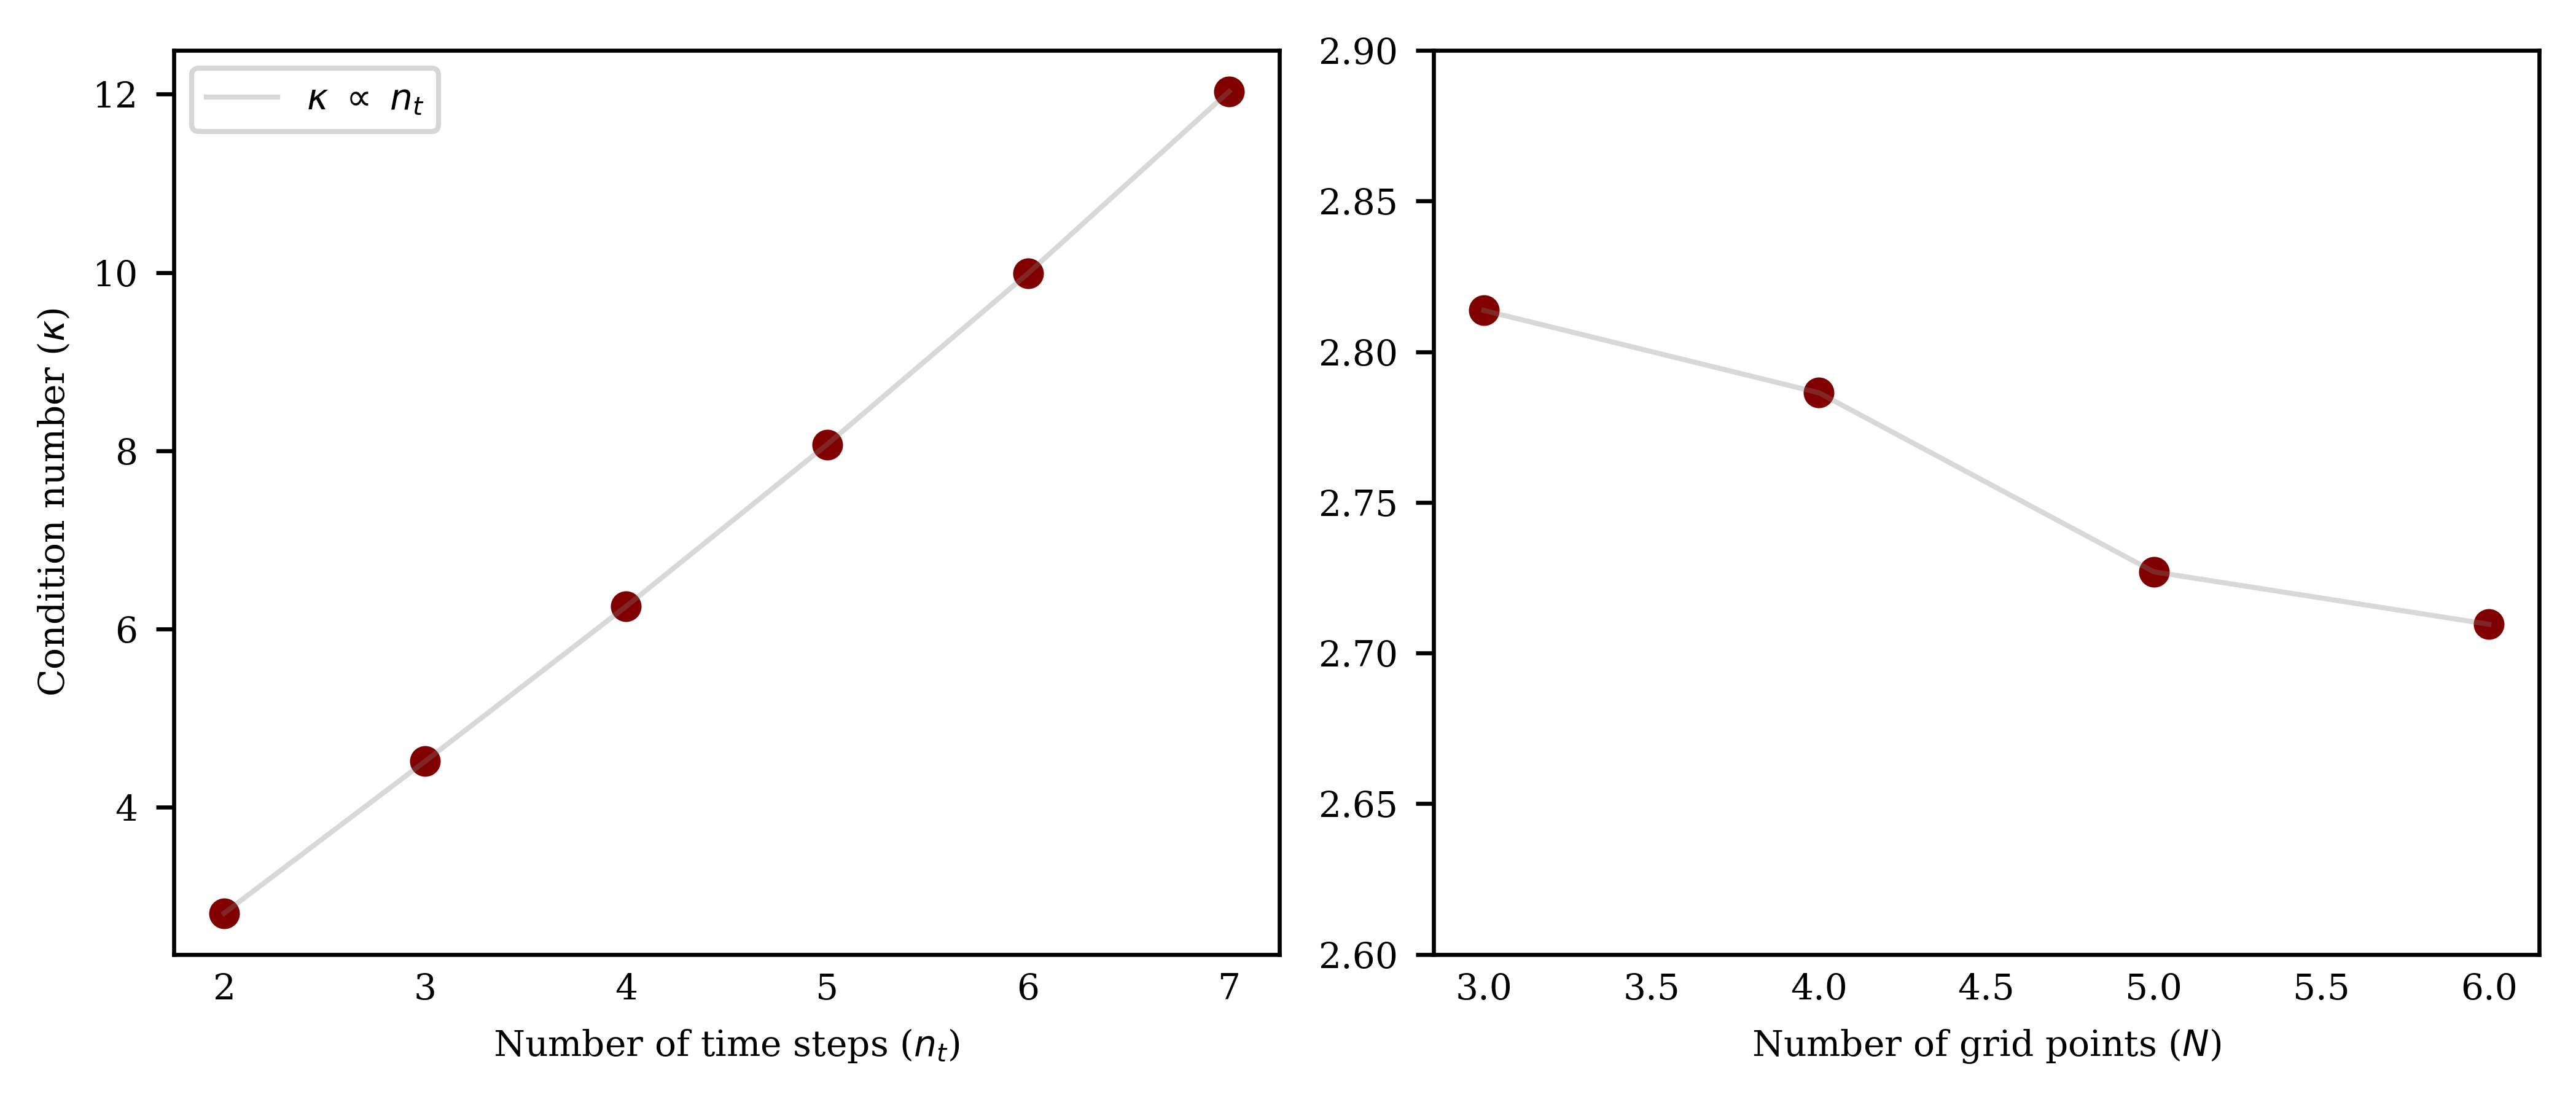

In [21]:
from matplotlib import pyplot as plt
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(7,3))

# Subplot 1: Epsilons vs. Depths
axes[0].plot(N_time_list[:], kappas_time[:], linestyle='-', alpha=0.3, color='gray', label='$\kappa$ $\propto$ $n_t$')
axes[0].scatter(N_time_list[:], kappas_time[:], color='maroon', s=25)

axes[0].set_xlabel('Number of time steps ($n_t$)')
axes[0].set_ylabel('Condition number ($\kappa$)')

# Subplot 2: Kappas vs. Depths
axes[1].plot(N_grid_list[:], kappas_gp[:], linestyle='-', alpha=0.3, color='gray')#, label='$\kappa$ $\propto$ $?$')
axes[1].scatter(N_grid_list[:], kappas_gp[:], color='maroon', s=25)
axes[1].set_xlabel('Number of grid points ($N$)')
axes[1].set_ylim(2.6,2.9)

axes[0].legend()

# Display the plots
fig.tight_layout()
plt.show()

In [8]:
N_grid = 3
h_init = [3,1,1]
u_init = [0,0,0]
N_time = 20  # Number of time steps
print("the num of grid points is: ", N_grid)
print("the num of time steps is: ", N_time)

Gen = LBM_2_Carlemann1(N_grid, h_init, u_init )

F1,F2,F3, f1,f2,f3  = Gen.gen_F()

A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1,F2,F3)

Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
Cs, B11,B22,B33,S = Gen.gen_streaming()

CL_LBE_Matrix =  Cc-Cs

N_grid = Gen.Nx

print("Shape of CL_LBE_Matrix is", CL_LBE_Matrix.shape)

def embed_matrix(C, delta_t, num_steps):
    """
    Embeds a matrix C into a larger matrix A with specified properties.

    Parameters:
        C (np.ndarray): The matrix to embed (must be square).
        delta_t (float): The length of each time step.
        num_steps (int): The number of time steps (and thus of cascaded blocks in A).

    Returns:
        np.ndarray: The constructed matrix A.
    """
    # Validate inputs
    if not (isinstance(C, np.ndarray) and C.ndim == 2 and C.shape[0] == C.shape[1]):
        raise ValueError("C must be a square matrix.")

    # Identity matrix with the same size as C
    Id = np.eye(C.shape[0])

    # Compute -O = -(Id + delta_t * C)
    O = -(Id + delta_t * C)

    # Size of the large matrix A
    A_size = num_steps * C.shape[0]

    # Initialize A as a zero matrix
    A = np.zeros((A_size, A_size))

    # Fill in the diagonal blocks
    for i in range(num_steps):
        # Main diagonal (Identity blocks)
        start_idx = i * C.shape[0]
        A[start_idx:start_idx + C.shape[0], start_idx:start_idx + C.shape[0]] = Id

        # Secondary diagonal (-O blocks)
        if i > 0:
            prev_idx = (i - 1) * C.shape[0]
            A[start_idx:start_idx + C.shape[0], prev_idx:prev_idx + C.shape[0]] = O

    return A

delta_t = Gen.delta_t
Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
print("Shape of the Matrix to invert:", Lin_Euler_Matrix.shape)
# print("kappa =", np.linalg.cond(Lin_Euler_Matrix))

the num of grid points is:  3
the num of time steps is:  20
Just made collision matrix...no time step addition
Just made streaming matrix...no time step addition
Shape of CL_LBE_Matrix is (819, 819)
Shape of the Matrix to invert: (16380, 16380)


In [9]:
def initial_distribution(Nx,h,u):

    #if velocities are null everywhere
    #initial_distribution = np.kron(Gen.h,(1/6,2/3,1/6))

    distr = np.zeros((Nx,3))

    for g in range (Nx):
        for i in range(3):
            if i==0:
                distr[g,i]= h[g]*(1/6 - u[g]/2)
            if i==1:
                distr[g,i]= h[g]*2/3
            if i==2:
                distr[g,i]= h[g]*(1/6 + u[g]/2)
            
    initial_distribution = np.hstack([distr[g,:] for g in range (Gen.Nx)])  # Function of 3 values in the 1D case
    
    return initial_distribution


def append_zeros(f, N):
    # Ensure `f` is a NumPy array
    f = np.array(f)

    # Create N zero vectors of the same shape as `f`
    zero_vector = np.zeros_like(f)
    zeros_to_append = np.tile(zero_vector, (N-1,))

    # Concatenate `f` with the appended zeros
    result = np.concatenate([f, zeros_to_append])

    return result

f1 = initial_distribution(Gen.Nx, Gen.h, Gen.u)
f2 = np.kron(f1,f1)
f3 = np.kron(f2,f1)

phi_t0 = np.hstack((f1,f2,f3))

phi = append_zeros(phi_t0, N_time)
print("about to invert the matrix")
Inverted_matrix = np.linalg.inv(Lin_Euler_Matrix)
print("Just inverted the matrix")
x = np.dot(Inverted_matrix, phi)

about to invert the matrix
Just inverted the matrix


In [10]:
grid_evolution = np.zeros((N_grid,N_time,3))

subvector_dim = 3 * N_grid + 9 * N_grid**2 + 27 * N_grid**3
print("Subvector dimension:", subvector_dim)

# Extract phi components for each time step
phi = extract_phi(x, subvector_dim, N_time)

# Extract the first 3 * N values from each phi_i
truncated_phi = phi_truncation(phi, N_grid)

# Divide each truncated phi into N groups of 3 and combine them
three_dim_vectors = divide_truncated_phi(truncated_phi, N_grid)

# Display the results
for i, vec in enumerate(three_dim_vectors, start=0):
    #print(f"Grid {i % Gen.Nx} at time { i // Gen.Nx}: {vec}")
    grid_evolution[i % Gen.Nx, i // Gen.Nx,:] = vec

#heigth
h = np.zeros((N_grid,N_time))
u = np.zeros((N_grid,N_time))

for t in range (N_time):
    print("Timestep", t)
    for g in range (N_grid):
        h[g, t] = sum(grid_evolution[g,t,:])
        print(f"Grid {g} height: {h[g,t]}")
    print("")

for t in range (N_time):
    print("Timestep", t)
    for g in range (N_grid):
        u[g, t] = sum(Gen.e*grid_evolution[g,t,:])/h[g,t]
        print(f"Grid {g} velocity: {u[g,t]}")
    print("")

Subvector dimension: 819
Timestep 0
Grid 0 height: 2.9999999999999996
Grid 1 height: 0.9999999999999999
Grid 2 height: 0.9999999999999999

Timestep 1
Grid 0 height: 2.9467874290915335
Grid 1 height: 1.0532125720581202
Grid 2 height: 1.0000000001642362

Timestep 2
Grid 0 height: 2.898292772535842
Grid 1 height: 1.0969879335749189
Grid 2 height: 1.0047192965869935

Timestep 3
Grid 0 height: 2.854515985442357
Grid 1 height: 1.131778200896975
Grid 2 height: 1.0137058178057454

Timestep 4
Grid 0 height: 2.815416929308415
Grid 1 height: 1.1579954576394371
Grid 2 height: 1.026587618702239

Timestep 5
Grid 0 height: 2.780919216368975
Grid 1 height: 1.1760117498144143
Grid 2 height: 1.0430690410243555

Timestep 6
Grid 0 height: 2.7509133717846113
Grid 1 height: 1.1861594221984488
Grid 2 height: 1.0629272148306534

Timestep 7
Grid 0 height: 2.725259346909823
Grid 1 height: 1.188731763667154
Grid 2 height: 1.0860088998873871

Timestep 8
Grid 0 height: 2.7037884137665613
Grid 1 height: 1.183983934

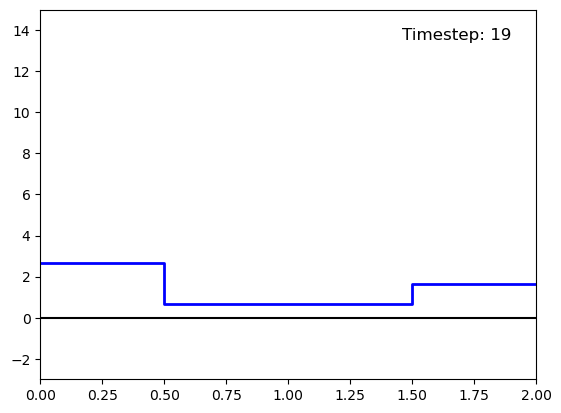

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Example 2D array of heights: rows are timesteps (t), columns are grid points (g)
timesteps = N_time
grid_points = Gen.Nx

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim([0, grid_points - 1])  # Set x-axis limits to the number of grid points
ax.set_ylim(-3, 15)  # Adjust the y-axis to fit the height data
# Add a placeholder for the timestep text
timestep_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', va='top', fontsize=12)
ax.axhline(y=0, color='black', linestyle='-')  # Adds a horizontal dashed line at y=0


# Initialize the line object (empty initially)
line, = ax.step([], [], where='mid', lw=2, color='blue')  # Line object to plot the profile
x = np.arange(grid_points)  # x values represent the grid points (g)

# Animation function: updates the line plot with heights at each timestep
def animate(t):
    y = h[:, t]  # Heights at all grid points for timestep t
    line.set_data(x, y)  # Set the x and y data for the line plot
    timestep_text.set_text(f'Timestep: {t}')  # Display current timestep
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, animate, repeat=True, frames=timesteps, interval=10000)
writer = animation.PillowWriter(fps=0.5)
ani.save('height_profile.gif', writer=writer)
plt.show()